## **Establish connection with GitHub using SSH protocol.**

In [1]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ssh keys were generated earlier. Private and Public keys are stored in 
# 'colabkey' and 'colabkey.pub' files. Additionally a config file is also 
# stored in /content/drive/MyDrive/ssh_keys/ on google drive.

# Remove ssh folder and its contents if already present
!rm -rf /root/.ssh

# Create a directory
!mkdir /root/.ssh

# Copy everything (ssh_key files & config file) from google drive to Virtual Machine.  
!cp /content/drive/MyDrive/ssh_keys/* /root/.ssh

# Set permission
!chmod 700 /root/.ssh

In [3]:
# Add the git server as an ssh known host
!touch /root/.ssh/known_hosts

# Trust github  
!ssh-keyscan github.com >> /root/.ssh/known_hosts

# Set permission  
!chmod 644 /root/.ssh/known_hosts

# github.com:22 SSH-2.0-babeld-fa4461bf
# github.com:22 SSH-2.0-babeld-fa4461bf
# github.com:22 SSH-2.0-babeld-fa4461bf
# github.com:22 SSH-2.0-babeld-fa4461bf
# github.com:22 SSH-2.0-babeld-fa4461bf


In [4]:
# Run ssh-agent and add `ssh-add /root/.ssh/colabkey` in the prompt. 
# After this command, optinally check if the key is saved using `ssh-add -l`, 
# then exit the prompt.
!ssh-agent /bin/bash

bash: cannot set terminal process group (242): Inappropriate ioctl for device
bash: no job control in this shell
/content# ssh-add /root/.ssh/colabkey
Identity added: /root/.ssh/colabkey (shreyasdb99@gmail.com)
/content# exit
exit


In [5]:
# Check connection with github
!ssh -T git@github.com

Hi shre-db! You've successfully authenticated, but GitHub does not provide shell access.


In [6]:
# Navigate to the project folder  # Please note that you need to remove this line of comment while running the cd command below.
cd drive/MyDrive/ColabProjects/Transfer-Learning-ResNet18-VGG16

/content/drive/MyDrive/ColabProjects/Transfer-Learning-ResNet18-VGG16


In [7]:
!ls

data  notebook.ipynb  README.md


## **Initialize git repository if not already**

In [8]:
# # Initialize the directory as a git repository (if not already)
# !git init

Initialized empty Git repository in /content/drive/MyDrive/ColabProjects/Transfer-Learning-ResNet18-VGG16/.git/


In [9]:
# # Configure user name and email (if not already)
# !git config user.name "shre-db"
# !git config user.email "shreyasdb99@gmail.com"

In [10]:
# # Check Staging Area
# !git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	notebook.ipynb

nothing added to commit but untracked files present (use "git add" to track)


In [11]:
# # Add Commit and Push
# !echo "# Transfer Learning with ResNet-18 and VGG-16" >> README.md
# !git add README.md notebook.ipynb
# !git commit -m "Add README and notebook" -m "This commit includes a README file and a notebook containing code for preliminary setup."
# !git branch -M main
# !git remote add origin git@github.com:shre-db/Transfer-Learning-ResNet18-VGG16.git
# !git push -u origin main

[master (root-commit) ac214fb] Add README and notebook
 2 files changed, 2 insertions(+)
 create mode 100644 README.md
 create mode 100644 notebook.ipynb
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (4/4), 2.80 KiB | 478.00 KiB/s, done.
Total 4 (delta 0), reused 0 (delta 0)
To github.com:shre-db/Transfer-Learning-ResNet18-VGG16.git
 * [new branch]      main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


## **Use cells in this section to execute commands**

In [86]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   notebook.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.data/
	data/

no changes added to commit (use "git add" and/or "git commit -a")


In [87]:
!git pull

Already up to date.


In [ ]:
!git add notebook.ipynb
!git commit -m "Update notebook" -m "Used ResNet-18 and VGG16 pretrained model on STL10 dataset after tuni"
!git push

## **Working with data**

In [47]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt

In [48]:
# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [49]:
# Apply transformations to the images
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# import data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset = torchvision.datasets.STL10(root='.data', download=True, split='test', transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [64]:
# translate to dataloaders
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=512)

In [65]:
# Inspect shape of the datasets
print(f'Train data shape: {trainset.data.shape}')
print(f'Test data shape: {testset.data.shape}')

# Range of pixel intensity values
print(f'Min: {np.min(trainset.data)}, Max: {np.max(testset.data)}')

# print unique categories
print(f'categories {trainset.classes}')

Train data shape: (5000, 3, 96, 96)
Test data shape: (8000, 3, 96, 96)
Min: 0, Max: 255
categories ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


The images need to be `3 x height x width` and they are not yet normalized. The transformations however are defined, but they are not applied until they are loaded from a dataLoader.

## **ResNet-18**

In [66]:
resnet = torchvision.models.resnet18(weights='IMAGENET1K_V1')

In [67]:
# Inspect the resnet model
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [68]:
from torchsummary import summary
summary(resnet.to(device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [69]:
# Freeze all layers
for p in resnet.parameters():
  p.requires_grad=False

In [70]:
# Modify the final layer
resnet.fc = nn.Linear(512, 10)

In [71]:
# Push the model to the GPU
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [72]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0005)

In [73]:
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  resnet.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = resnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  # test performance
  resnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = resnet(X)
      loss = lossfun(yHat,y)
    
    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')


Finished epoch 1/10. Test accuracy = 68.46%
Finished epoch 2/10. Test accuracy = 75.09%
Finished epoch 3/10. Test accuracy = 77.05%
Finished epoch 4/10. Test accuracy = 77.17%
Finished epoch 5/10. Test accuracy = 77.67%
Finished epoch 6/10. Test accuracy = 78.13%
Finished epoch 7/10. Test accuracy = 78.43%
Finished epoch 8/10. Test accuracy = 78.69%
Finished epoch 9/10. Test accuracy = 78.37%
Finished epoch 10/10. Test accuracy = 78.76%


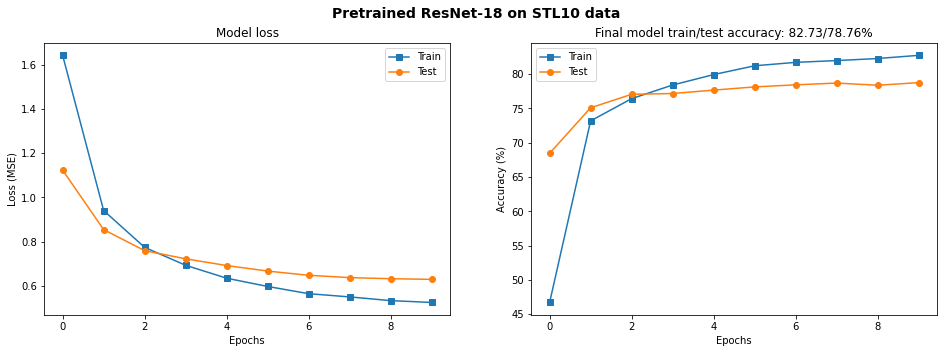

In [74]:

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

## **VGG-16**

In [75]:
vgg = torchvision.models.vgg16(weights='IMAGENET1K_V1')

In [76]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [77]:
summary(vgg.to(device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [78]:
# Freeze all layers
for p in vgg.parameters():
  p.requires_grad=False

In [79]:
# Modify the final layer
vgg.classifier[6] = nn.Linear(4096, 10)

In [80]:
# Push the model to GPU
vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [82]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.0005)

In [83]:
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  vgg.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = vgg(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  # test performance
  resnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = vgg(X)
      loss = lossfun(yHat,y)
    
    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')


Finished epoch 1/10. Test accuracy = 89.03%
Finished epoch 2/10. Test accuracy = 89.69%
Finished epoch 3/10. Test accuracy = 89.64%
Finished epoch 4/10. Test accuracy = 89.76%
Finished epoch 5/10. Test accuracy = 89.76%
Finished epoch 6/10. Test accuracy = 89.73%
Finished epoch 7/10. Test accuracy = 90.28%
Finished epoch 8/10. Test accuracy = 90.04%
Finished epoch 9/10. Test accuracy = 89.76%
Finished epoch 10/10. Test accuracy = 90.17%


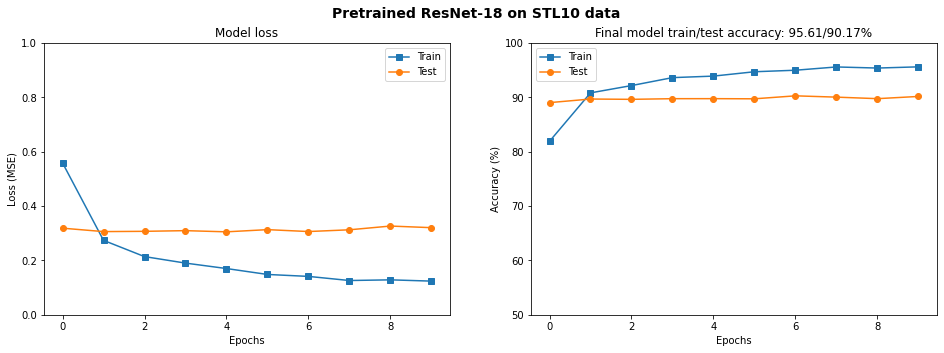

In [85]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].set_ylim(0, 1)
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].set_ylim(50, 100)
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

VGG performed better than ResNet in this case with test accuracy of 90% compared to ResNet's 79%.